In [537]:
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

In [538]:
df = pd.read_csv("data/untitled.txt")
df = df.drop(columns='Unnamed: 0')

In [539]:
df

,iso_code,location,continent,date,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,positive_rate,human_development_index,cost_living_index,tourist_service_index,international_travel_controls
0,ALB,Albania,Europe,2020-02-25,NaN,NaN,8.33,NaN,0.795,35.50,4.01,1.0
1,ALB,Albania,Europe,2020-02-26,NaN,NaN,8.33,NaN,0.795,35.50,4.01,1.0
2,ALB,Albania,Europe,2020-02-27,NaN,NaN,8.33,NaN,0.795,35.50,4.01,1.0
3,ALB,Albania,Europe,2020-02-28,NaN,NaN,8.33,NaN,0.795,35.50,4.01,1.0
4,ALB,Albania,Europe,2020-02-29,NaN,NaN,8.33,NaN,0.795,35.50,4.01,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
88602,ZWE,Zimbabwe,Africa,2022-03-22,0.000,16.811,NaN,0.0841,0.571,45.68,2.95,NaN
88603,ZWE,Zimbabwe,Africa,2022-03-23,18.089,12.381,NaN,0.0648,0.571,45.68,2.95,NaN
88604,ZWE,Zimbabwe,Africa,2022-03-24,15.637,14.615,NaN,0.0802,0.571,45.68,2.95,NaN
88605,ZWE,Zimbabwe,Africa,2022-03-25,29.883,15.457,NaN,NaN,0.571,45.68,2.95,NaN


In [540]:
medians = df.groupby(["iso_code"]).median()

In [541]:
medians

,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,positive_rate,human_development_index,cost_living_index,tourist_service_index,international_travel_controls
iso_code,,,,,,,,
ALB,58.3030,86.7700,56.48,0.1670,0.795,35.50,4.01,2.0
ARE,98.4380,98.9455,54.63,0.0076,0.890,58.33,5.63,2.0
ARG,153.4455,151.1790,77.31,0.1830,0.845,34.69,4.53,3.0
ARM,109.6650,119.0265,NaN,0.1185,0.776,33.89,4.33,NaN
AUS,1.2800,1.0750,65.28,0.0009,0.944,77.75,6.06,4.0
...,...,...,...,...,...,...,...,...
VNM,0.1220,0.1130,67.13,0.0719,0.704,37.48,2.85,4.0
YEM,0.1970,0.2340,27.78,NaN,0.470,53.14,1.87,3.0
ZAF,38.9060,41.2240,50.93,0.0939,0.709,42.09,4.30,1.0


In [542]:
medians = medians.fillna(df.median())

/tmp/ipykernel_2690/4062631757.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medians = medians.fillna(df.median())


In [543]:
medians

,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,positive_rate,human_development_index,cost_living_index,tourist_service_index,international_travel_controls
iso_code,,,,,,,,
ALB,58.3030,86.7700,56.48,0.1670,0.795,35.50,4.01,2.0
ARE,98.4380,98.9455,54.63,0.0076,0.890,58.33,5.63,2.0
ARG,153.4455,151.1790,77.31,0.1830,0.845,34.69,4.53,3.0
ARM,109.6650,119.0265,57.41,0.1185,0.776,33.89,4.33,3.0
AUS,1.2800,1.0750,65.28,0.0009,0.944,77.75,6.06,4.0
...,...,...,...,...,...,...,...,...
VNM,0.1220,0.1130,67.13,0.0719,0.704,37.48,2.85,4.0
YEM,0.1970,0.2340,27.78,0.0590,0.470,53.14,1.87,3.0
ZAF,38.9060,41.2240,50.93,0.0939,0.709,42.09,4.30,1.0


In [544]:
corr = medians.corr()
corr.style.background_gradient(cmap='coolwarm')

,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,positive_rate,human_development_index,cost_living_index,tourist_service_index,international_travel_controls
new_cases_per_million,1.000000,0.914938,0.053519,0.070644,0.500498,0.120721,0.455251,-0.030952
new_cases_smoothed_per_million,0.914938,1.000000,0.046726,0.086815,0.512850,0.183527,0.498469,-0.038522
stringency_index,0.053519,0.046726,1.000000,0.092060,0.056014,-0.150721,-0.000776,0.278064
positive_rate,0.070644,0.086815,0.092060,1.000000,-0.107649,-0.322670,-0.119444,-0.280216
human_development_index,0.500498,0.512850,0.056014,-0.107649,1.000000,0.634269,0.825188,0.347224
cost_living_index,0.120721,0.183527,-0.150721,-0.322670,0.634269,1.000000,0.602240,0.279560
tourist_service_index,0.455251,0.498469,-0.000776,-0.119444,0.825188,0.602240,1.000000,0.246671
international_travel_controls,-0.030952,-0.038522,0.278064,-0.280216,0.347224,0.279560,0.246671,1.000000


Correlated columns:

- new_cases_per_million and new_cases_smoothed_per_million (keep new_cases_smoothed_per_million)
- human_development_index and tourist_service_index (keep tourist_service_index)

In [545]:
medians = medians.drop(columns = ["new_cases_per_million", "human_development_index"])

In [546]:
medians

,new_cases_smoothed_per_million,stringency_index,positive_rate,cost_living_index,tourist_service_index,international_travel_controls
iso_code,,,,,,
ALB,86.7700,56.48,0.1670,35.50,4.01,2.0
ARE,98.9455,54.63,0.0076,58.33,5.63,2.0
ARG,151.1790,77.31,0.1830,34.69,4.53,3.0
ARM,119.0265,57.41,0.1185,33.89,4.33,3.0
AUS,1.0750,65.28,0.0009,77.75,6.06,4.0
...,...,...,...,...,...,...
VNM,0.1130,67.13,0.0719,37.48,2.85,4.0
YEM,0.2340,27.78,0.0590,53.14,1.87,3.0
ZAF,41.2240,50.93,0.0939,42.09,4.30,1.0


In [547]:
# not a true quantitative column
medians = medians.drop(columns = ["international_travel_controls"])

In [548]:
medians

,new_cases_smoothed_per_million,stringency_index,positive_rate,cost_living_index,tourist_service_index
iso_code,,,,,
ALB,86.7700,56.48,0.1670,35.50,4.01
ARE,98.9455,54.63,0.0076,58.33,5.63
ARG,151.1790,77.31,0.1830,34.69,4.53
ARM,119.0265,57.41,0.1185,33.89,4.33
AUS,1.0750,65.28,0.0009,77.75,6.06
...,...,...,...,...,...
VNM,0.1130,67.13,0.0719,37.48,2.85
YEM,0.2340,27.78,0.0590,53.14,1.87
ZAF,41.2240,50.93,0.0939,42.09,4.30


In [549]:
medians = pd.DataFrame(normalize(medians), columns = medians.columns, index = medians.index)

In [550]:
dists = pd.DataFrame(
    squareform(pdist(medians)),
    columns = medians.index,
    index = medians.index
)

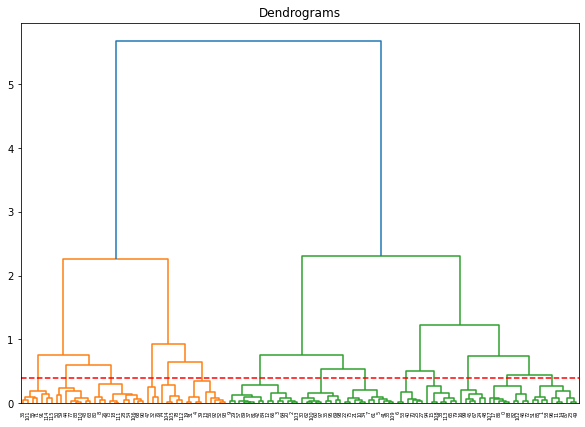

In [551]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(medians, method='ward'))
plt.axhline(y=0.4, color='r', linestyle='--')
plt.show()

In [552]:
nclusters = 14

In [553]:
cluster = AgglomerativeClustering(n_clusters=nclusters, affinity='euclidean', linkage='ward')  

In [554]:
cluster.fit_predict(medians)

array([ 6,  9,  2,  2,  0,  3, 12,  3,  1,  2,  3,  9,  2,  0,  9, 13,  8,
        6,  1,  0,  2,  3,  3,  9,  8, 12,  1, 12,  1,  2, 11,  0,  5,  3,
        3, 11,  7,  2, 13,  0, 12,  3,  2, 10, 10,  8,  6,  5,  8,  9, 10,
        9,  0, 12,  1,  7,  0,  2,  9, 10, 11,  3, 11, 10,  2, 13,  2,  8,
        1, 11, 12,  7,  6,  1,  4,  3,  5, 10,  4, 13,  1,  2,  6, 10,  2,
        9,  6,  9,  6,  2,  1,  7,  0,  0, 13, 11,  9, 11, 11,  8, 11,  7,
        6,  2,  4,  4,  1,  6, 13,  3, 10,  1,  4, 13,  7,  7])

In [555]:
medians["hcluster"] = cluster.fit_predict(medians)

In [556]:
iso_location = df[["iso_code", "location"]].drop_duplicates()

In [557]:
medians

,new_cases_smoothed_per_million,stringency_index,positive_rate,cost_living_index,tourist_service_index,hcluster
iso_code,,,,,,
ALB,0.792251,0.515689,0.001525,0.324132,0.036613,6
ARE,0.777180,0.429098,0.000060,0.458160,0.044222,9
ARG,0.872021,0.445934,0.001056,0.200097,0.026130,2
ARM,0.872030,0.420606,0.000868,0.248290,0.031723,2
AUS,0.010570,0.641840,0.000009,0.764447,0.059583,0
...,...,...,...,...,...,...
VNM,0.001469,0.872530,0.000935,0.487151,0.037043,1
YEM,0.003900,0.463055,0.000983,0.885772,0.031170,4
ZAF,0.528541,0.652984,0.001204,0.539644,0.055131,13


In [558]:
iso_location

,iso_code,location
0,ALB,Albania
761,DZA,Algeria
1522,ARG,Argentina
2338,ARM,Armenia
3121,AUS,Australia
...,...,...
84878,VEN,Venezuela
85621,VNM,Vietnam
86415,YEM,Yemen
87131,ZMB,Zambia


In [559]:
medians = pd.merge(medians, iso_location, on="iso_code")

In [560]:
for i in range(nclusters):
    print(list(medians[medians["hcluster"] == i]["location"]))
    print()

['Australia', 'Barbados', 'Cameroon', 'Ethiopia', 'Hong Kong', 'Japan', 'South Korea', 'Senegal', 'Singapore']

['Bangladesh', 'China', 'Algeria', 'Egypt', 'Kenya', 'Myanmar', 'Nigeria', 'Pakistan', 'Rwanda', 'Uganda', 'Vietnam']

['Argentina', 'Armenia', 'Bulgaria', 'Brazil', 'Colombia', 'Spain', 'Greece', 'Hungary', 'Kuwait', 'Moldova', 'North Macedonia', 'Panama', 'Poland', 'Russia', 'Turkey']

['Austria', 'Belgium', 'Bahrain', 'Costa Rica', 'Cyprus', 'France', 'United Kingdom', 'Croatia', 'Luxembourg', 'Netherlands', 'United States']

['Nicaragua', 'New Zealand', 'Taiwan', 'Tanzania', 'Yemen']

['Finland', 'Iceland', 'Norway']

['Albania', 'Chile', 'Iran', 'Malaysia', 'Peru', 'Paraguay', 'Romania', 'Tunisia', 'Ukraine']

['Ghana', 'Cambodia', 'Mauritius', 'Saudi Arabia', 'Thailand', 'Zambia', 'Zimbabwe']

['Switzerland', 'Denmark', 'Ireland', 'Israel', 'Malta', 'Sweden']

['United Arab Emirates', 'Bolivia', 'Botswana', 'Germany', 'Italy', 'Jordan', 'Lebanon', 'Portugal', 'Qatar', '